# Yeast G-Protein Cycle

In [3]:
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy

In [4]:
sys.path.append('../..')
import spatialpy

In [17]:
class PheromoneGradient(spatialpy.DataFunction):
    def __init__(self, a=0.0, b=1.0, L_min=0, L_max=4, MOLAR=1.0):
        """ 1D domain from a to b. """
        spatialpy.DataFunction.__init__(self, name="PheromoneGradient")
        self.a = a
        self.b = b
        self.L_min = L_min
        self.L_max = L_max
        self.MOLAR = MOLAR

    def expression(self):
        ret =  f"({(self.L_max - self.L_min) * 0.5} * (1 + cos(0.5*me->x[0])) + {self.L_min}) * {self.MOLAR}"
        return ret
    
    def map(self, x): #for visualization
        ret =  ((self.L_max - self.L_min) * 0.5 * (1 + math.cos(0.5*x[0])) + self.L_min) * self.MOLAR
        return ret


class G_protein_cycle_1D(spatialpy.Model):

    def __init__(self,model_name="G_protein_cycle_1D"):
        spatialpy.Model.__init__(self,model_name)

        # Species
        # R RL G Ga Gbg Gd
        R   = spatialpy.Species(name="R",  diffusion_constant=0.01)
        RL  = spatialpy.Species(name="RL", diffusion_constant=0.01)
        G   = spatialpy.Species(name="G",  diffusion_constant=0.01)
        Ga  = spatialpy.Species(name="Ga", diffusion_constant=0.01)
        Gbg = spatialpy.Species(name="Gbg",diffusion_constant=0.01)
        Gd  = spatialpy.Species(name="Gd", diffusion_constant=0.01)
        
        self.add_species([R,RL,G,Ga,Gbg,Gd])
    
        L = 4*3.14159
        NUM_VOXELS = 200
        MOLAR=6.02e-01*((L/NUM_VOXELS)**3)
        self.domain = spatialpy.Domain.create_2D_domain(
            ny=1, nx=NUM_VOXELS, xlim=(-2*numpy.pi, 2*numpy.pi), ylim=(0,1) )
        
        SA    = spatialpy.Parameter(name="SA" ,expression=201.056)
        V     = spatialpy.Parameter(name="V" ,expression=33.5)
        k_RL  = spatialpy.Parameter(name="k_RL" ,expression=2e-03/MOLAR)
        k_RLm = spatialpy.Parameter(name="k_RLm" ,expression=1e-02)
        k_Rs  = spatialpy.Parameter(name="k_Rs" ,expression="4.0/SA")
        k_Rd0 = spatialpy.Parameter(name="k_Rd0" ,expression=4e-04)
        k_Rd1 = spatialpy.Parameter(name="k_Rd1" ,expression=4e-04)
        k_G1  = spatialpy.Parameter(name="k_G1" ,expression="1.0*SA")
        k_Ga  = spatialpy.Parameter(name="k_Ga" ,expression="1e-06*SA")
        k_Gd  = spatialpy.Parameter(name="k_Gd" ,expression=0.1)
        self.add_parameter([SA,V,k_RL,k_RLm,k_Rs,k_Rd0,k_Rd1,k_G1,k_Ga,k_Gd]) 

        # Add Data Function to model the mating pheromone gradient.
        self.add_data_function(PheromoneGradient(a=-2*3.14159, b=2*3.14159, MOLAR=MOLAR))

        # Reactions
        R0 = spatialpy.Reaction(name="R0", reactants={}, products={R:1}, massaction=True, rate=k_Rs)
        R1 = spatialpy.Reaction(name="R1", reactants={R:1}, products={}, massaction=True, rate=k_Rd0)
        R2 = spatialpy.Reaction(name="R2", reactants={R:1}, products={RL:1}, 
                                propensity_function="k_RL*R*PheromoneGradient/vol")
        R3 = spatialpy.Reaction(name="R3", reactants={RL:1}, products={R:1}, massaction=True, rate=k_RLm)
        R4 = spatialpy.Reaction(name="R4", reactants={RL:1}, products={}, massaction=True, rate=k_RLm)
        R5 = spatialpy.Reaction(name="R5", reactants={G:1}, products={Ga:1, Gbg:1}, 
                                propensity_function="k_Ga*RL*G/vol")
        R6 = spatialpy.Reaction(name="R6", reactants={Ga:1}, products={Gd:1}, massaction=True, rate=k_Ga)
        R7 = spatialpy.Reaction(name="R7", reactants={Gd:1, Gbg:1}, products={G:1}, massaction=True, rate=k_G1)
        self.add_reaction([R0,R1,R2,R3,R4,R5,R6,R7])
        
        # Distribute molecules randomly over the mesh according to their initial values
        self.add_initial_condition(spatialpy.ScatterInitialCondition(R,10000))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(G,10000))

        self.timespan(range(11))

### Generate the model and run the simulation

In [15]:
model = G_protein_cycle_1D()

In [16]:
%time result = model.run()

CPU times: user 196 ms, sys: 1.61 ms, total: 198 ms
Wall time: 3min 5s


### Output graphs of the spatial profiles of the species in the G-Protein cycle

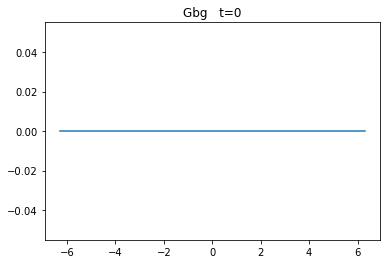

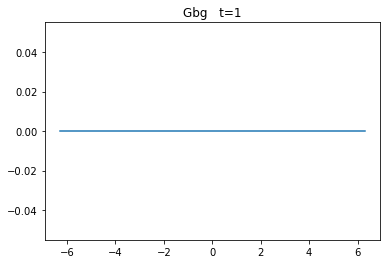

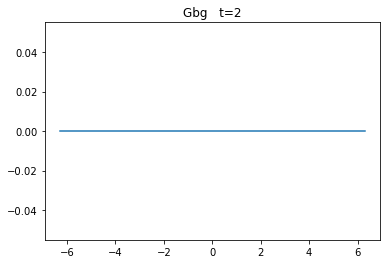

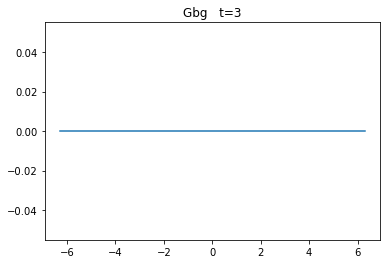

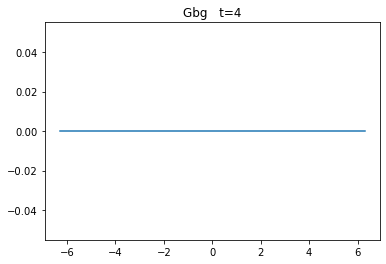

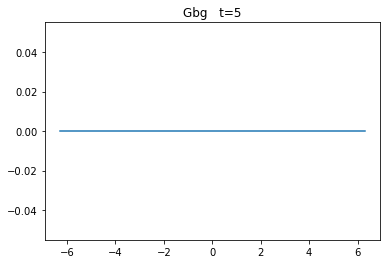

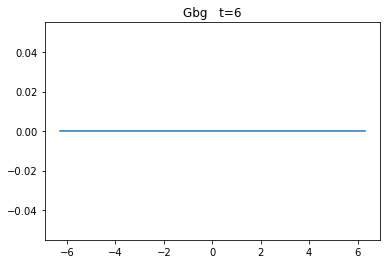

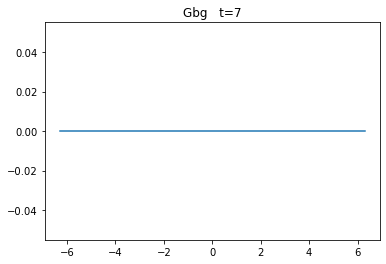

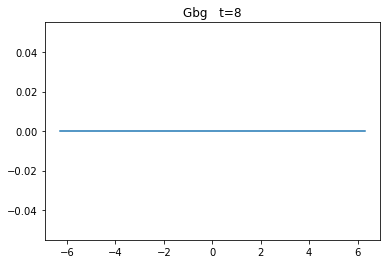

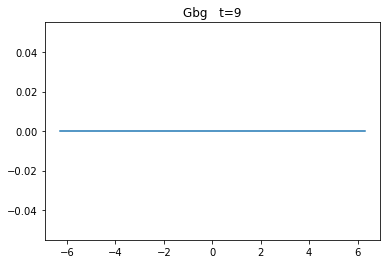

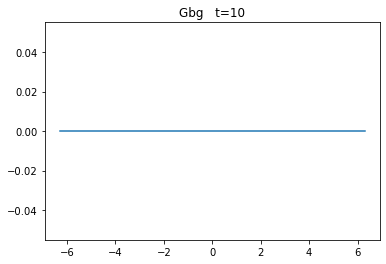

In [20]:
import time
from IPython.display import display, clear_output
x_vals = model.domain.coordinates()[:,0]
sname = "Gbg"
for n in range(0, len(result.get_timespan())):
    S = result.get_species(sname, timepoints=n)
    #time.sleep(.05)
    plt.plot(x_vals, S)
    plt.title('{1}   t={0}'.format(n, sname))
    #clear_output()
    plt.show() 

Text(0.5, 1.0, 'RL   t=10')

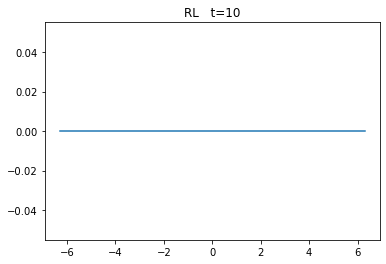

In [21]:
sname = "RL"
S = result.get_species(sname, timepoints=n)
plt.plot(x_vals, S)
plt.title('{1}   t={0}'.format(n, sname))

Text(0.5, 1.0, 'G   t=10')

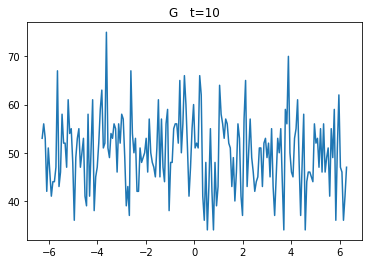

In [22]:
sname = "G"
S = result.get_species(sname, timepoints=n)
plt.plot(x_vals, S)
plt.title('{1}   t={0}'.format(n, sname))

Text(0.5, 1.0, 'Ga   t=10')

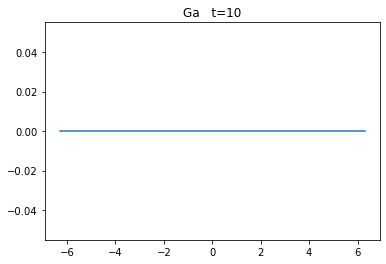

In [23]:
sname = "Ga"
S = result.get_species(sname, timepoints=n)
plt.plot(x_vals, S)
plt.title('{1}   t={0}'.format(n, sname))

Text(0.5, 1.0, 'Gd   t=10')

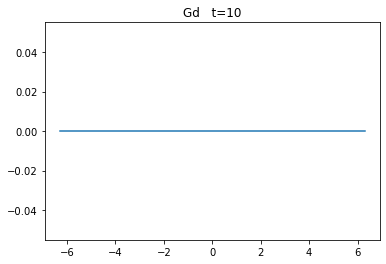

In [24]:
sname = "Gd"
S = result.get_species(sname, timepoints=n)
plt.plot(x_vals, S)
plt.title('{1}   t={0}'.format(n, sname))

Text(0.5, 1.0, 'R   t=10')

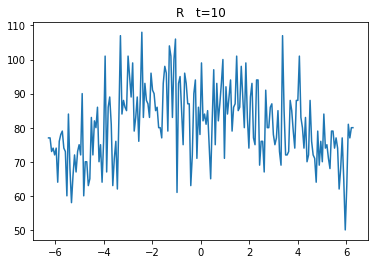

In [25]:
sname = "R"
S = result.get_species(sname, timepoints=n)
plt.plot(x_vals, S)
plt.title('{1}   t={0}'.format(n, sname))

Text(0.5, 1.0, 'Input: External gradient of pheromone')

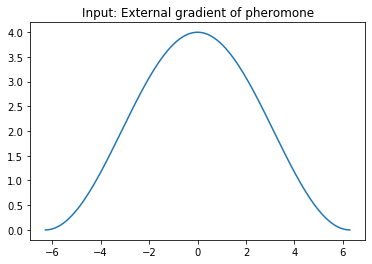

In [27]:
L = 4*3.14159
NUM_VOXEL = 200
MOLAR=6.02e-01*((L/NUM_VOXEL)**3)
x_vals = model.domain.coordinates()[:, 0]
pg = PheromoneGradient()
gradient = [pg.map([x]) for x in x_vals]
plt.plot(x_vals, gradient)
plt.title('Input: External gradient of pheromone')